In [28]:
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple, Union
from tqdm.notebook import tqdm

import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [29]:
plt.style.use("ggplot")

# View Data

In [30]:
@dataclass
class Features:
    sample_rate: int = 22050
    hop_length: int = 220
    n_fft: int = 2048
    n_frames_per_example: int = 1


def load_wav(path: Union[str, Path], sample_rate: int) -> np.ndarray:
    waveform, _ = librosa.load(path, sr=sample_rate)
    return waveform


def extract_features(file_path: Union[str, Path], params: Features) -> List[np.ndarray]:
    waveform = load_wav(file_path, sample_rate=params.sample_rate)

    spectrogram = librosa.feature.melspectrogram(
        y=waveform, n_fft=params.n_fft, 
        hop_length=params.hop_length
    )

    spectrogram = np.log(1e-20 + np.abs(spectrogram**2))

    n_examples = spectrogram.shape[1] // params.n_frames_per_example

    return [
        spectrogram[
            :, i * params.n_frames_per_example : (i + 1) * params.n_frames_per_example
        ].reshape(1, -1)
        for i in range(n_examples)
    ]

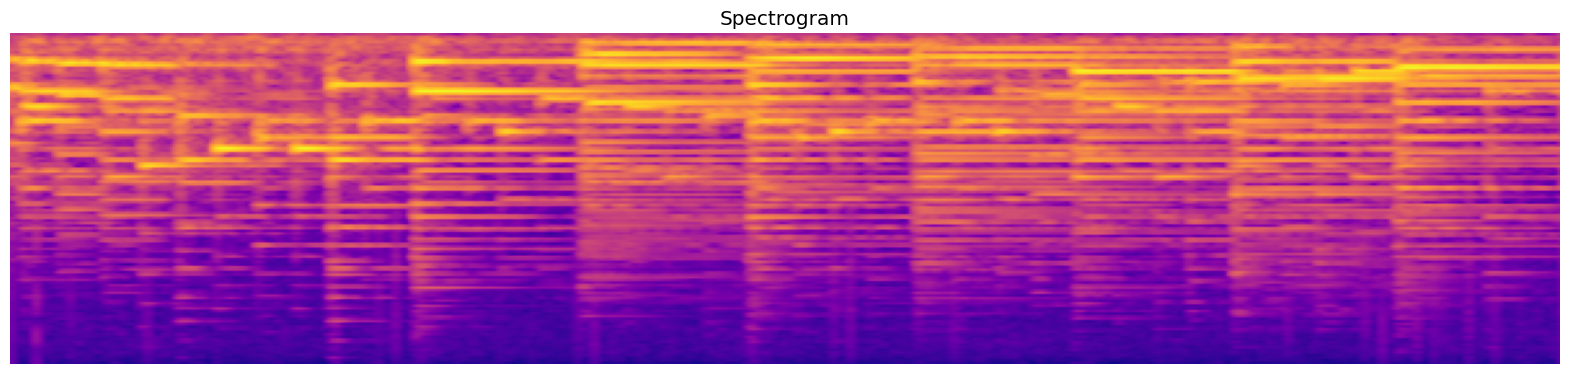

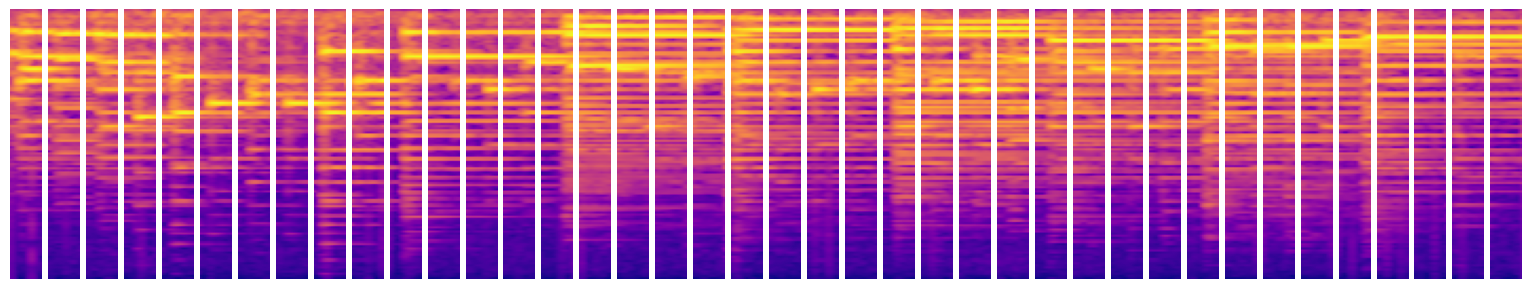

In [31]:
# 1161154212832220511.wav
# 1429195257218202828.wav

PATH = "./train/train/classical/1429195257218202828.wav"
PARAMS = Features(n_frames_per_example=15)

ipd.display(ipd.Audio(PATH))

sample_features = [
    feature.reshape(-1, PARAMS.n_frames_per_example)
    for feature in extract_features(file_path=PATH, params=PARAMS)
]

plt.figure(figsize=(20, 5))
plt.title("Spectrogram")
plt.imshow(np.hstack(sample_features), cmap="plasma")
plt.axis("off")
plt.savefig("spectrogram.png", dpi=200)
plt.show()

plt.figure(figsize=(20, 5))
for i, feature in enumerate(sample_features):
    plt.subplot(1, len(sample_features) + 1, i + 1)
    plt.imshow(feature, cmap="plasma")
    plt.axis("off")
plt.show()

# Prepare Train Dataset

In [32]:
def load_folder_data(
    path: Path, train: bool, params: Features
) -> Tuple[List[List[np.ndarray]], List[List[str]], List[Path]]:
    features: List[List[np.ndarray]] = []
    labels: List[List[str]] = []
    file_names: List[Path] = list(path.rglob("*.wav"))

    for file_path in file_names:
        file_features = extract_features(file_path, params)

        features.append(file_features)

        if train:
            class_name = file_path.parent.name
            labels.append([class_name] * len(file_features))

    return features, labels, file_names

In [33]:
@dataclass
class ExpConfig:
    features: Features = Features(
        sample_rate = 22050,
        hop_length = 220,
        n_fft= 2048,
        n_frames_per_example= 1,
    )
    random_state: int = 42
    test_size: float = 0.1
    train_path: Path = Path("./train/train")
    test_path: Path = Path("./test/test")


config = ExpConfig()

In [35]:
class_names = [folder.name for folder in config.train_path.iterdir()]

class_name2id: Dict[str, int] = {
    class_name: class_id for class_id, class_name in enumerate(class_names)
}

features, labels, file_names = load_folder_data(
    path=config.train_path, train=True, params=config.features
)

labels_int: List[List[int]] = [
    [class_name2id[label] for label in label_list] for label_list in labels
]

In [36]:
(
    features_train,
    features_test,
    labels_train,
    labels_test,
    files_train,
    files_test,
) = train_test_split(
    features,
    labels_int,
    file_names,
    random_state=config.random_state,
    test_size=config.test_size,
)

In [37]:
X_train_full = np.vstack([x for list_ in features_train for x in list_])
y_train_full = np.array([x for list_ in labels_train for x in list_])

In [38]:
from sklearn.model_selection import train_test_split
 
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    train_size=0.05, 
    random_state=42,
    stratify=y_train_full
)

In [39]:
X_train.shape

(121904, 128)

In [40]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0 12010]
 [    1 12250]
 [    2 12431]
 [    3 12040]
 [    4 12431]
 [    5 12010]
 [    6 12582]
 [    7 11980]
 [    8 12040]
 [    9 12130]]


In [51]:
%%time

# sgd = Pipeline([("scaler", StandardScaler()), ("clf", SGDClassifier(loss="log", n_jobs=-1))]).fit(
#     X_train, y_train
# )

# tree = Pipeline([("scaler", StandardScaler()), ("clf", DecisionTreeClassifier())]).fit(
#     X_train, y_train
# )

# forest = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(n_jobs=-1))]).fit(
#     X_train, y_train
# )

params = {
    "n_estimators":1000, 
    "max_depth":6, 
    "n_jobs":-1,
    "verbosity":0
}
xgboost = Pipeline([("scaler", StandardScaler()), ("clf", XGBClassifier(params))]).fit(
    X_train, y_train
)

# knn = Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier(n_neighbors=5, n_jobs=-1))]).fit(
#     X_train, y_train
# )

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


KeyboardInterrupt: 

# Interpretation

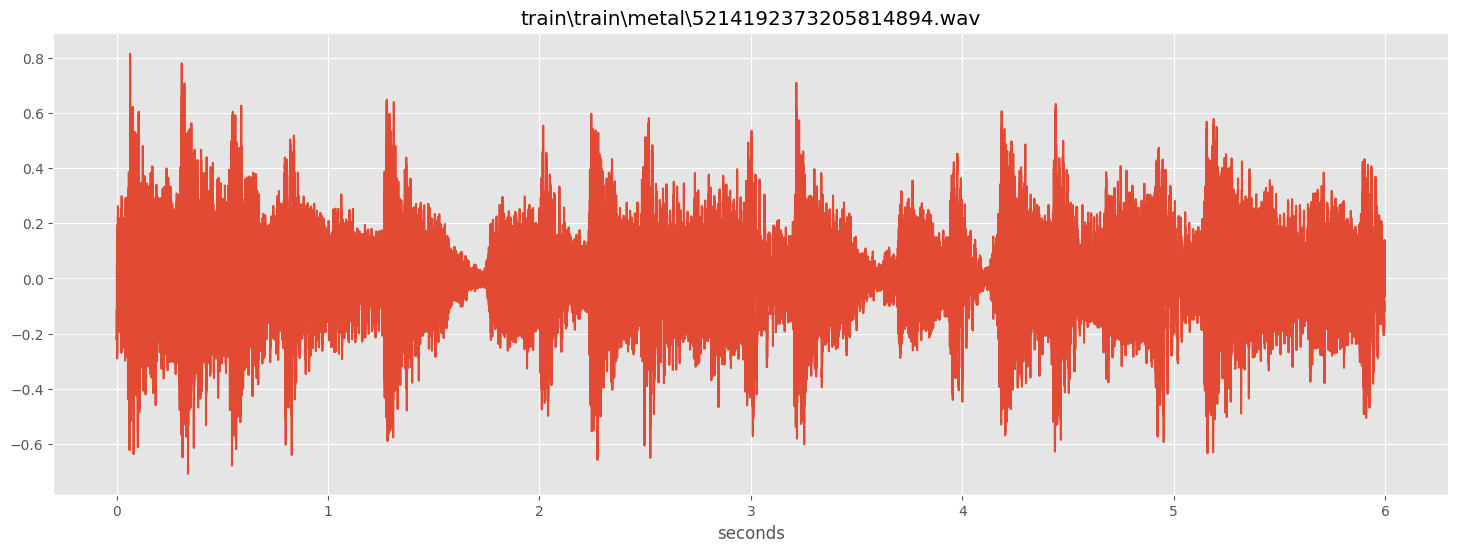

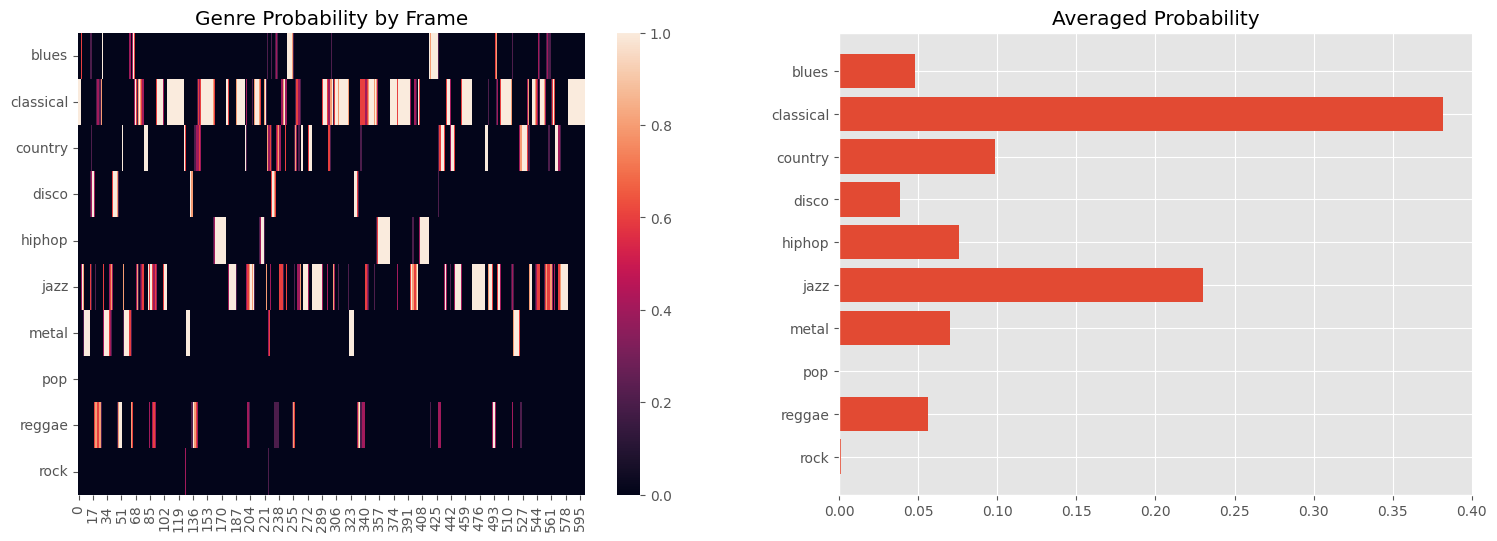

In [42]:
TEST_ID = 892

predictions = knn.predict_proba(np.vstack(features_train[TEST_ID]))

plt.figure(figsize=(18, 6))
plt.title(files_train[TEST_ID])
wave_form = load_wav(files_train[TEST_ID], sample_rate=config.features.sample_rate)
time_axis = [x / config.features.sample_rate for x in range(wave_form.size)]
plt.plot(time_axis, wave_form)
plt.xlabel("seconds")
plt.show()

ipd.display(ipd.Audio(files_train[TEST_ID]))
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.title("Genre Probability by Frame")
sns.heatmap(predictions.T, yticklabels=class_names)

plt.subplot(122)
plt.title("Averaged Probability")
plt.barh(class_names, predictions.mean(0))
plt.gca().invert_yaxis()
plt.show()

## Confusion matrix

In [43]:
def plot_conf_matrix(
    y_test: np.ndarray, y_pred: np.ndarray, class_names: List[str], annot: bool = False
) -> None:
    plt.figure(figsize=(8, 6))
    plt.title(f"Accuracy: {(y_test == y_pred).mean():.2f}")
    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        xticklabels=class_names,
        yticklabels=class_names,
        linewidths=0.5,
        annot=annot,
    )
    plt.show()

### by frame

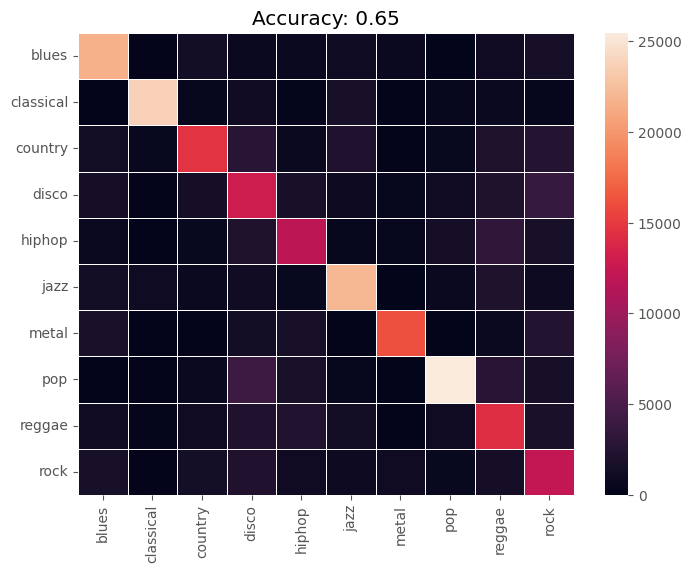

In [44]:
X_test = np.vstack(
    [feature for feature_list in features_test for feature in feature_list]
)

y_test = np.array([label for label_list in labels_test for label in label_list])

y_pred = xgboost.predict(X_test)

plot_conf_matrix(y_pred, y_test, class_names)

### by record

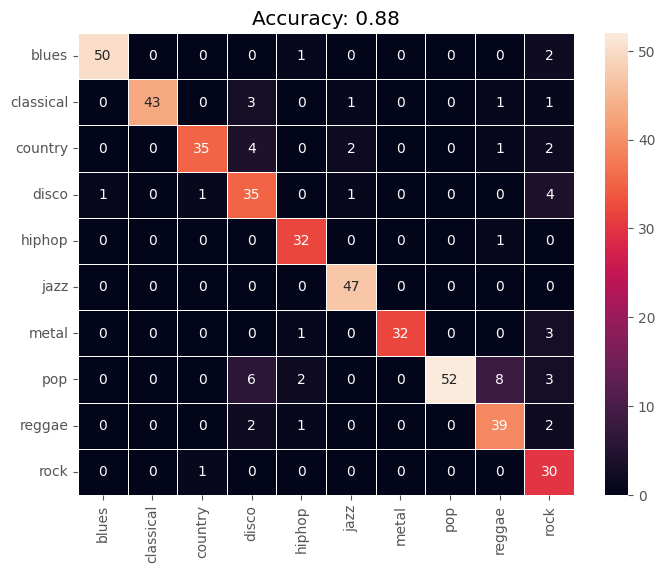

In [45]:
y_pred = np.array(
    [
        xgboost.predict_proba(np.vstack(feature_list)).mean(0).argmax()
        for feature_list in features_test
    ]
)

y_test = np.array([label_list[0] for label_list in labels_test])

plot_conf_matrix(y_pred, y_test, class_names, annot=True)

# Test

In [47]:
test_features, _, test_pathes = load_folder_data(
    config.test_path, train=False, params=config.features
)

In [49]:
predictions = [
    class_names[xgboost.predict_proba(np.vstack(test_feature)).mean(0).argmax()]
    for test_feature in test_features
]

In [50]:
(
    pd.DataFrame(
        {
            "index": [
                test_wav_path.name for test_wav_path in config.test_path.iterdir()
            ],
            "genre": predictions,
        }
    ).to_csv("submit.csv", index=False)
)